# Obrada prirodnog jezika za razumijevanje povratnih informacija klijenata u ugostiteljskoj industriji

## Potrebni moduli

In [29]:
import re
import os
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Učitavanje podataka

In [ ]:
# Za prikazivanje cijelih komentara
pd.set_option("max_colwidth", 100)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5


## EDA

In [ ]:
# Vrijednosti koje nedostaju
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [ ]:
df.Rating.describe()

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

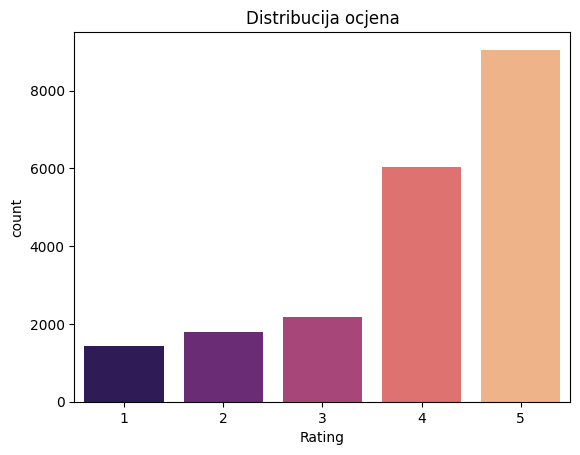

In [ ]:
# Distribucija ocjena
sns.countplot(data=df, x="Rating", palette="magma").set_title("Distribucija ocjena");

In [ ]:
# Duljina review-a (char)
df['Length'] = df['Review'].str.len()
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [ ]:
# Duljina review-a (riječ)
def word_count(review):
    review_list = review.split()
    return len(review_list)

df['Word count'] = df['Review'].apply(word_count)
df.head()

,Review,Rating,Length,Word count
0,nice hotel expensive parking got good deal sta...,4,593,87
1,ok nothing special charge diamond member hilto...,2,1689,250
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217
3,"unique, great stay, wonderful time hotel monac...",5,600,89
4,"great stay great stay, went seahawk game aweso...",5,1281,191


In [ ]:
# Deskriptivna statistika
df.Length.describe()

count    20491.000000
mean       724.896833
std        689.101024
min         44.000000
25%        339.000000
50%        537.000000
75%        859.000000
max      13501.000000
Name: Length, dtype: float64

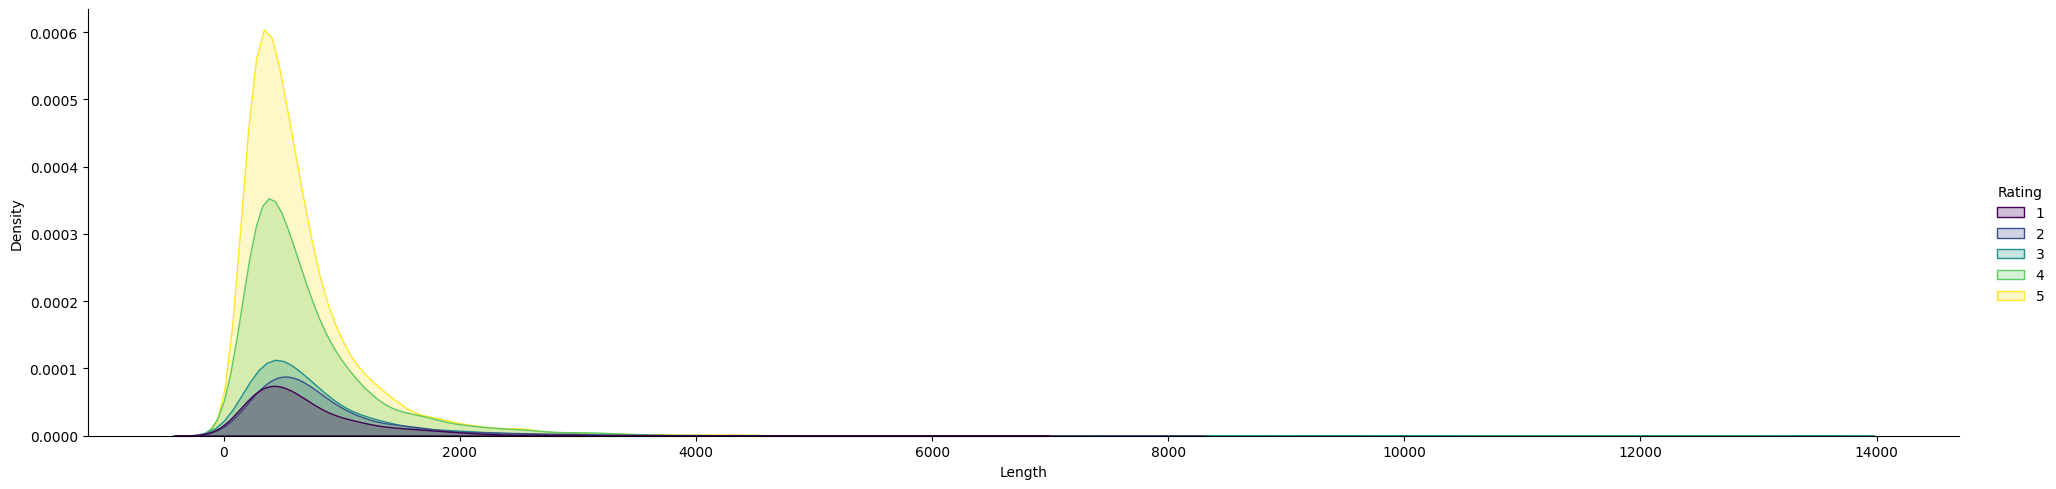

In [ ]:
sns.displot(data=df, x="Length", hue="Rating", palette="viridis", kind="kde", fill=True, aspect=4);

In [ ]:
df['Word count'].describe()

count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Word count, dtype: float64

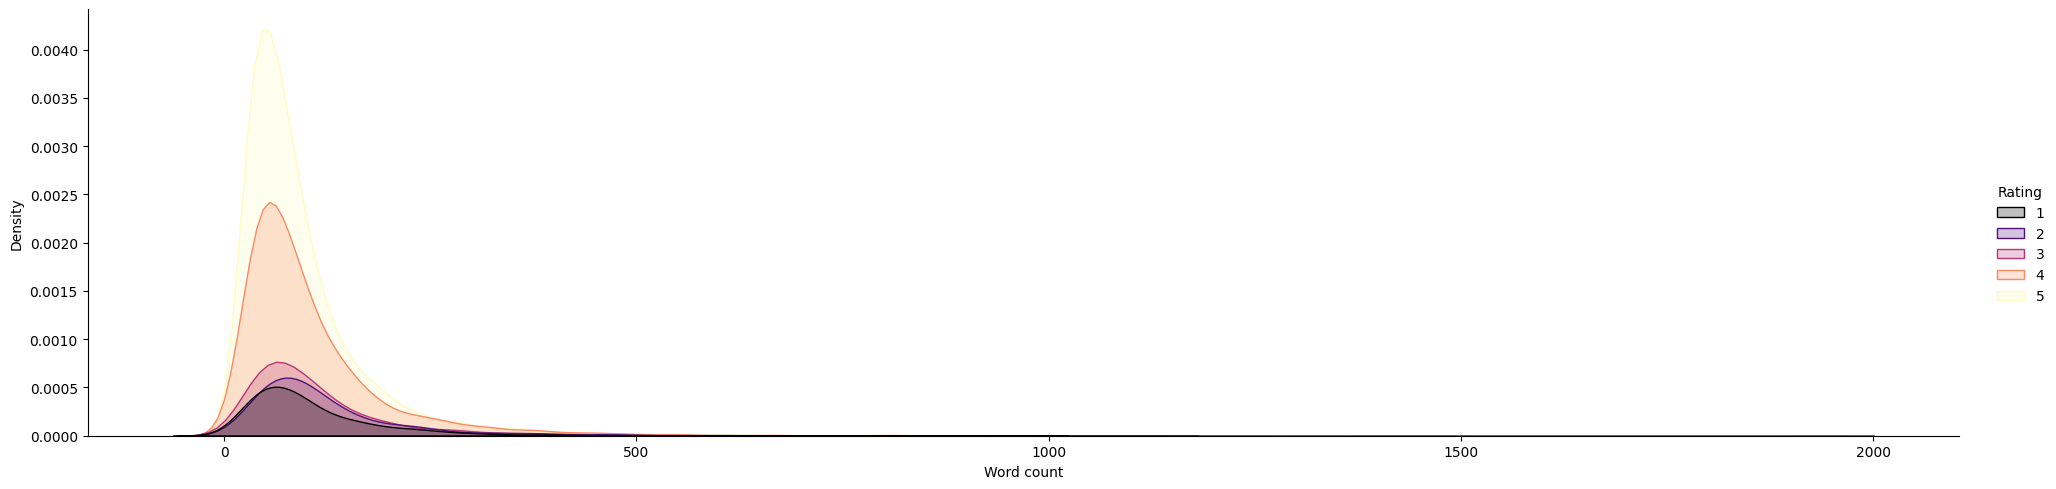

In [ ]:
sns.displot(data=df, x="Word count", hue="Rating", palette="magma", kind="kde", fill=True, aspect=4);

## Najzastupljenije riječi i *n*-grami

In [ ]:
df.drop(['Length', 'Word count'], axis = 1, inplace = True)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review) # uklanjanje specijalnih znakova
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [ ]:
df['Review'] = df['Review'].apply(clean)

In [ ]:
def split_into_words(text):
    text_list = text.split()
    return text_list

df['Review_lists'] = df['Review'].apply(split_into_words)

In [ ]:
df.head()

,Review,Rating,Review_lists
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member..."
2,nice rooms 4 experience hotel monaco seattle g...,3,"[nice, rooms, 4, experience, hotel, monaco, se..."
3,unique great stay wonderful time hotel monaco ...,5,"[unique, great, stay, wonderful, time, hotel, ..."
4,great stay great stay went seahawk game awesom...,5,"[great, stay, great, stay, went, seahawk, game..."


In [ ]:
corpus = [word for review_list in df['Review_lists'] for word in review_list]
len(corpus)

2060911

In [ ]:
most_common_words = Counter(corpus).most_common(10)
most_common_words

[('hotel', 48844),
 ('room', 34279),
 ('great', 21068),
 ('nt', 18989),
 ('good', 16953),
 ('staff', 16193),
 ('stay', 15142),
 ('nice', 12393),
 ('rooms', 12005),
 ('location', 11009)]

In [ ]:
words, freq = zip(*most_common_words)

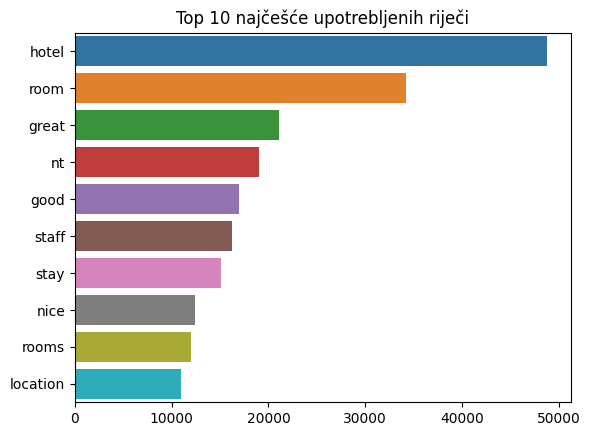

In [ ]:
sns.barplot(x=list(freq), y=list(words))
plt.title('Top 10 najčešće upotrebljenih riječi')
plt.show()

In [ ]:
def display_ngram(n, df):
  cv = CountVectorizer(ngram_range=(n,n))
  n_gram = cv.fit_transform(df['Review'])
  count_values = n_gram.toarray().sum(axis=0)
  ngram_df = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
  ngram_df.columns = ["frequency", "ngram"]

  sns.barplot(x=ngram_df['frequency'][:10], y=ngram_df['ngram'][:10])
  plt.title('Top 10 najčešćih n-grama')
  plt.show()

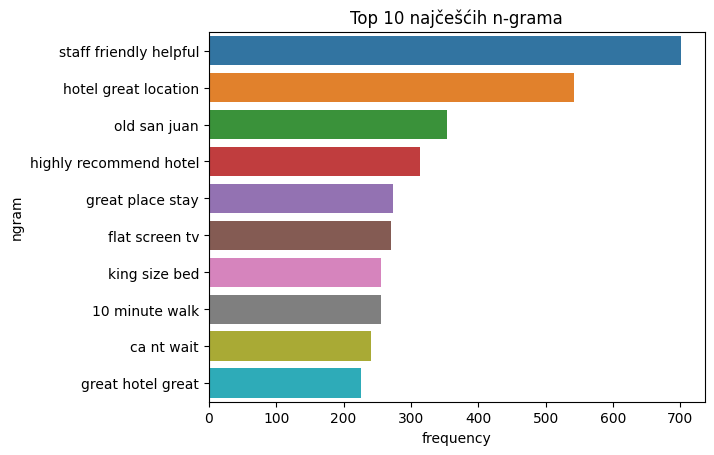

In [ ]:
n_gram = display_ngram(3, df)

## Analiza sentimenta sa sekvencijalnim modelima

In [95]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dense, Dropout, TextVectorization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from nltk.stem.snowball import SnowballStemmer

In [96]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [98]:
df['Label'] = df['Rating'].apply(lambda x: 0 if x in [1, 2] else (1 if x == 3 else 2))

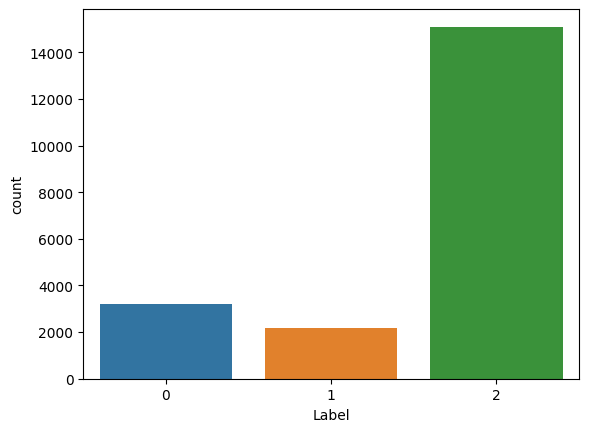

In [99]:
sns.countplot(x='Label', data=df);

In [106]:
X_train, X_test, y_train, y_test = train_test_split(df["Review"], df["Label"], test_size=0.2, random_state=72)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=72)

In [104]:
stop_words = set(stopwords.words('english'))
words_to_keep = {'not', 'no', 'nt', 'very'}
filtered_stop_words = stop_words - words_to_keep

stemmer = SnowballStemmer("english")

def custom_preprocessing_sw_removal(text):
    # text = text.lower
    # Uklanjanje interpunkcije
    text = re.sub(r'[^\w\s]', '', text)
    # Stemming i uklanjanje stopwordsa osim onih koji utječu na sentiment
    text = " ".join(stemmer.stem(word) for word in text.split() if word not in filtered_stop_words)

    return text

In [107]:
def custom_preprocessing_sw_removal(text):
    # Provjera je li tekst string i pretvaranje u string ako nije
    if not isinstance(text, str):
        text = str(text)

    # Pretvaranje teksta u mala slova
    text = text.lower()
    # Uklanjanje interpunkcije
    text = re.sub(r'[^\w\s]', '', text)
    # Stemming i uklanjanje stopwordsa osim onih koji utječu na sentiment
    text = " ".join(stemmer.stem(word) for word in text.split() if word not in filtered_stop_words)

    return text

In [108]:
X_train = X_train.apply(custom_preprocessing_sw_removal)
X_val = X_val.apply(custom_preprocessing_sw_removal)
X_test = X_test.apply(custom_preprocessing_sw_removal)

In [109]:
batch_size = 32
VOCAB_TOKENS = 5000

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_TOKENS)

encoder.adapt(train_ds.map(lambda text, labels: text))

np.array(encoder.get_vocabulary())[:20]

array(['', '[UNK]', 'hotel', 'room', 'not', 'stay', 'great', 'nt', 'good',
       'staff', 'night', 'locat', 'nice', 'day', 'time', 'no', 'servic',
       'clean', 'walk', 'restaur'], dtype='<U14')

In [110]:
def plot_metrics(history):
    metrics = pd.DataFrame(history.history)
    metrics[['accuracy', 'val_accuracy']].plot()
    metrics[['loss', 'val_loss']].plot()

### *Vanilla* RNN

Epoch 1/10
385/385 [==============================] - 275s 710ms/step - loss: 0.8479 - accuracy: 0.6908 - val_loss: 0.7476 - val_accuracy: 0.7457
Epoch 2/10
385/385 [==============================] - 257s 666ms/step - loss: 0.7403 - accuracy: 0.7539 - val_loss: 0.6295 - val_accuracy: 0.8036
Epoch 3/10
385/385 [==============================] - 252s 654ms/step - loss: 0.5917 - accuracy: 0.8023 - val_loss: 0.4993 - val_accuracy: 0.8277
Epoch 4/10
385/385 [==============================] - 246s 641ms/step - loss: 0.4681 - accuracy: 0.8395 - val_loss: 0.4482 - val_accuracy: 0.8377
Epoch 5/10
385/385 [==============================] - 251s 651ms/step - loss: 0.3811 - accuracy: 0.8614 - val_loss: 0.4720 - val_accuracy: 0.8267
Epoch 6/10
385/385 [==============================] - 249s 648ms/step - loss: 0.3095 - accuracy: 0.8827 - val_loss: 0.4853 - val_accuracy: 0.8331
Epoch 7/10
385/385 [==============================] - 252s 655ms/step - loss: 0.2537 - accuracy: 0.9042 - val_loss: 0.5162 -

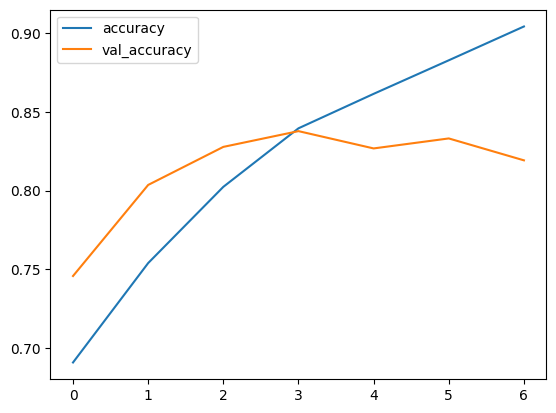

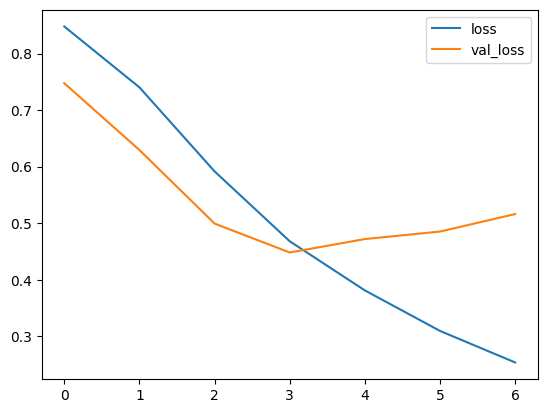

In [ ]:
rnn_model1 = Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    SimpleRNN(32),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')])

rnn_model1.compile(optimizer=Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = rnn_model1.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = rnn_model1.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 8s 64ms/step - loss: 0.5179 - accuracy: 0.8185
Test Loss: 0.5178619623184204
Test Accuracy: 0.8184922933578491


### GRU

Epoch 1/10
385/385 [==============================] - 43s 102ms/step - loss: 0.9326 - accuracy: 0.7655 - val_loss: 0.5474 - val_accuracy: 0.8211
Epoch 2/10
385/385 [==============================] - 24s 61ms/step - loss: 0.5159 - accuracy: 0.8387 - val_loss: 0.4896 - val_accuracy: 0.8397
Epoch 3/10
385/385 [==============================] - 18s 47ms/step - loss: 0.4508 - accuracy: 0.8570 - val_loss: 0.5005 - val_accuracy: 0.8397
Epoch 4/10
385/385 [==============================] - 14s 36ms/step - loss: 0.4127 - accuracy: 0.8630 - val_loss: 0.4769 - val_accuracy: 0.8402
Epoch 5/10
385/385 [==============================] - 12s 32ms/step - loss: 0.3732 - accuracy: 0.8742 - val_loss: 0.4754 - val_accuracy: 0.8394
Epoch 6/10
385/385 [==============================] - 10s 25ms/step - loss: 0.3485 - accuracy: 0.8817 - val_loss: 0.5019 - val_accuracy: 0.8365
Epoch 7/10
385/385 [==============================] - 12s 32ms/step - loss: 0.3088 - accuracy: 0.8967 - val_loss: 0.5346 - val_accuracy

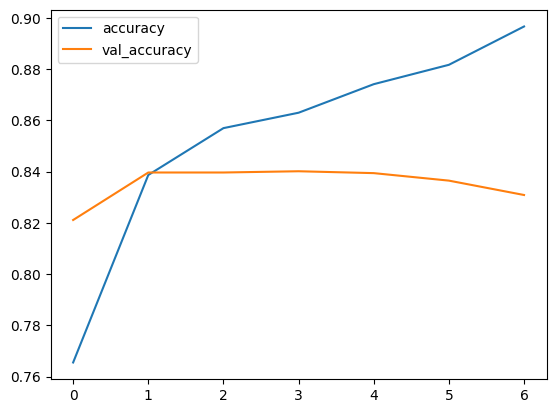

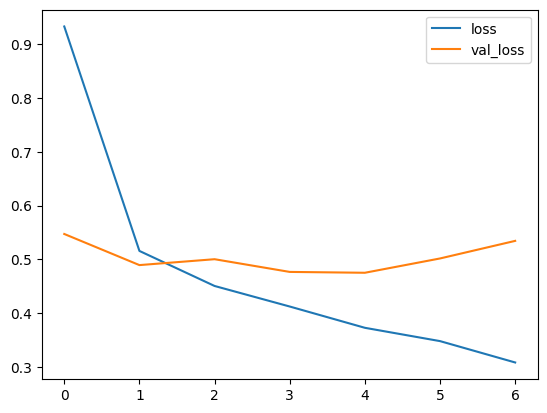

In [ ]:
gru_model = Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 100, mask_zero = True),
    GRU(32),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

gru_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = gru_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 17ms/step - loss: 0.5378 - accuracy: 0.8283
Test Loss: 0.5378349423408508
Test Accuracy: 0.8282507658004761


## Dvosmjerna GRU mreža

Epoch 1/10
385/385 [==============================] - 53s 117ms/step - loss: 0.9393 - accuracy: 0.7923 - val_loss: 0.5185 - val_accuracy: 0.8397
Epoch 2/10
385/385 [==============================] - 29s 75ms/step - loss: 0.4518 - accuracy: 0.8585 - val_loss: 0.4684 - val_accuracy: 0.8433
Epoch 3/10
385/385 [==============================] - 23s 61ms/step - loss: 0.3885 - accuracy: 0.8724 - val_loss: 0.4390 - val_accuracy: 0.8482
Epoch 4/10
385/385 [==============================] - 20s 51ms/step - loss: 0.3557 - accuracy: 0.8822 - val_loss: 0.4396 - val_accuracy: 0.8509
Epoch 5/10
385/385 [==============================] - 21s 54ms/step - loss: 0.3235 - accuracy: 0.8971 - val_loss: 0.4527 - val_accuracy: 0.8446
Epoch 6/10
385/385 [==============================] - 20s 51ms/step - loss: 0.3031 - accuracy: 0.9061 - val_loss: 0.4755 - val_accuracy: 0.8458
Epoch 7/10
385/385 [==============================] - 18s 48ms/step - loss: 0.2733 - accuracy: 0.9156 - val_loss: 0.5108 - val_accuracy

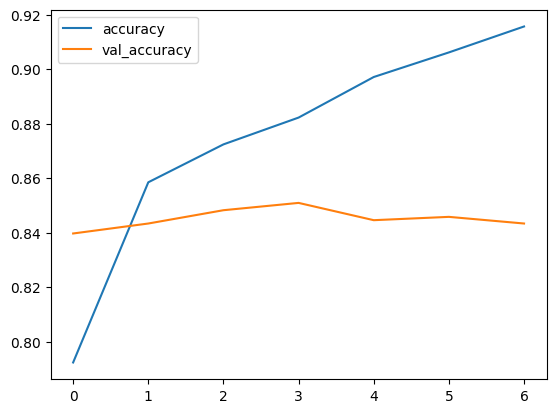

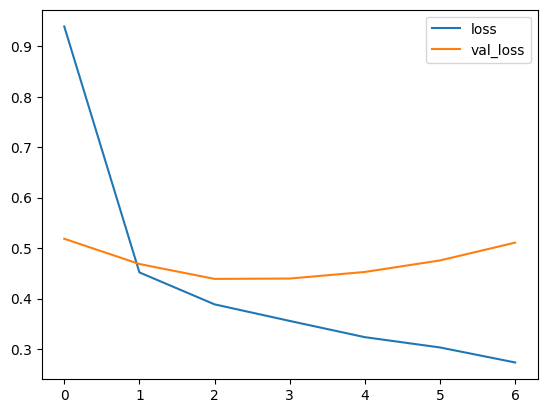

In [ ]:
bi_gru_model = tf.keras.models.Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    Bidirectional(GRU(32)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.4),
    Dense(3, activation='softmax')])

bi_gru_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_gru_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = bi_gru_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 3s 21ms/step - loss: 0.5400 - accuracy: 0.8297
Test Loss: 0.5399513840675354
Test Accuracy: 0.8297145366668701


## LSTM

Epoch 1/10
385/385 [==============================] - 65s 154ms/step - loss: 1.0781 - accuracy: 0.7600 - val_loss: 0.5881 - val_accuracy: 0.8353
Epoch 2/10
385/385 [==============================] - 30s 78ms/step - loss: 0.5529 - accuracy: 0.8224 - val_loss: 0.5216 - val_accuracy: 0.8402
Epoch 3/10
385/385 [==============================] - 20s 53ms/step - loss: 0.5134 - accuracy: 0.8389 - val_loss: 0.5691 - val_accuracy: 0.8375
Epoch 4/10
385/385 [==============================] - 18s 46ms/step - loss: 0.4643 - accuracy: 0.8517 - val_loss: 0.4838 - val_accuracy: 0.8402
Epoch 5/10
385/385 [==============================] - 16s 40ms/step - loss: 0.4647 - accuracy: 0.8480 - val_loss: 0.5097 - val_accuracy: 0.8314

Final val_accuracy: 83.14%



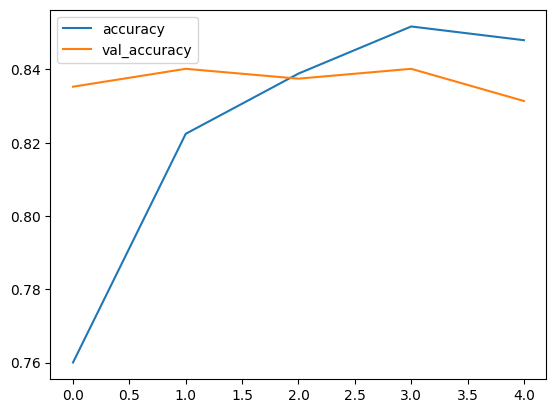

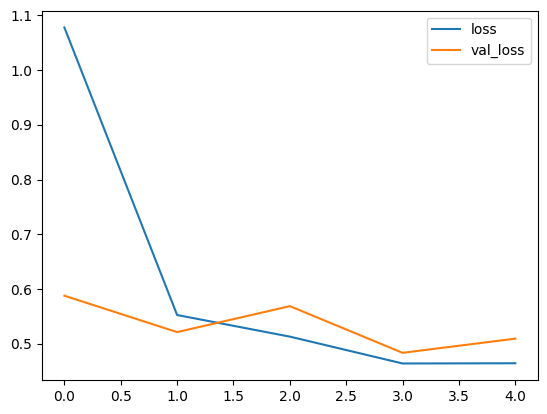

In [111]:
lstm_model = tf.keras.models.Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    LSTM(64),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

lstm_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = lstm_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = lstm_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 1s 11ms/step - loss: 0.5006 - accuracy: 0.8265
Test Loss: 0.5005931854248047
Test Accuracy: 0.8265430331230164


## Dvosmjerni LSTM

Epoch 1/20
385/385 [==============================] - 73s 160ms/step - loss: 1.0195 - accuracy: 0.8027 - val_loss: 0.4960 - val_accuracy: 0.8497
Epoch 2/20
385/385 [==============================] - 36s 94ms/step - loss: 0.5043 - accuracy: 0.8447 - val_loss: 0.5277 - val_accuracy: 0.8236
Epoch 3/20
385/385 [==============================] - 26s 68ms/step - loss: 0.4906 - accuracy: 0.8432 - val_loss: 0.5013 - val_accuracy: 0.8419
Epoch 4/20
385/385 [==============================] - 25s 65ms/step - loss: 0.4410 - accuracy: 0.8604 - val_loss: 0.4595 - val_accuracy: 0.8499
Epoch 5/20
385/385 [==============================] - 21s 54ms/step - loss: 0.4045 - accuracy: 0.8675 - val_loss: 0.4444 - val_accuracy: 0.8531
Epoch 6/20
385/385 [==============================] - 20s 51ms/step - loss: 0.3723 - accuracy: 0.8795 - val_loss: 0.4791 - val_accuracy: 0.8392
Epoch 7/20
385/385 [==============================] - 21s 54ms/step - loss: 0.3496 - accuracy: 0.8861 - val_loss: 0.4621 - val_accuracy

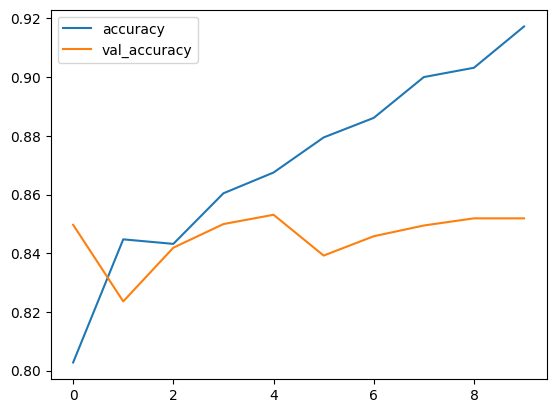

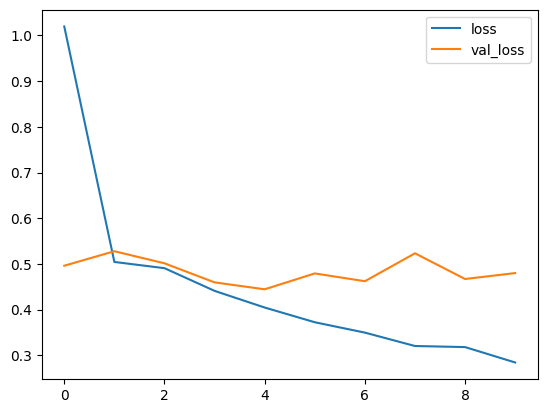

In [22]:
bi_lstm_model = tf.keras.models.Sequential([
    encoder,
    Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

bi_lstm_model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_lstm_model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = bi_lstm_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 16ms/step - loss: 0.4728 - accuracy: 0.8495
Test Loss: 0.4727649986743927
Test Accuracy: 0.8494755029678345


## GloVe

In [12]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-01-12 20:19:04--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-12 20:19:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  4.70MB/s    in 2m 45s  

2024-01-12 20:21:50 (4.98 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]



In [13]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [30]:
glove_path = './glove.6B.100d.txt'

embeddings_index = {}
with open(glove_path, 'r', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

In [31]:
vocab = encoder.get_vocabulary()
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab), embedding_dim))

for i, word in enumerate(vocab):
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

## BiLSTM model sa GloVe vektorima

Epoch 1/10
385/385 [==============================] - 22s 43ms/step - loss: 1.2384 - accuracy: 0.7509 - val_loss: 0.7478 - val_accuracy: 0.7962
Epoch 2/10
385/385 [==============================] - 14s 35ms/step - loss: 0.6215 - accuracy: 0.7980 - val_loss: 0.5680 - val_accuracy: 0.8070
Epoch 3/10
385/385 [==============================] - 16s 42ms/step - loss: 0.5691 - accuracy: 0.8100 - val_loss: 0.5198 - val_accuracy: 0.8194
Epoch 4/10
385/385 [==============================] - 14s 35ms/step - loss: 0.5343 - accuracy: 0.8185 - val_loss: 0.4883 - val_accuracy: 0.8411
Epoch 5/10
385/385 [==============================] - 14s 36ms/step - loss: 0.5081 - accuracy: 0.8254 - val_loss: 0.5280 - val_accuracy: 0.8253
Epoch 6/10
385/385 [==============================] - 14s 35ms/step - loss: 0.4762 - accuracy: 0.8339 - val_loss: 0.4615 - val_accuracy: 0.8421
Epoch 7/10
385/385 [==============================] - 14s 35ms/step - loss: 0.4544 - accuracy: 0.8446 - val_loss: 0.4637 - val_accuracy:

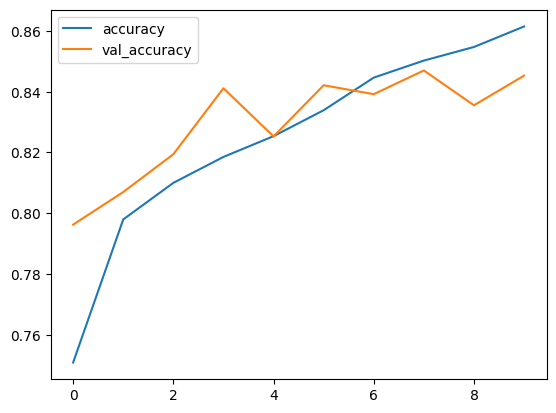

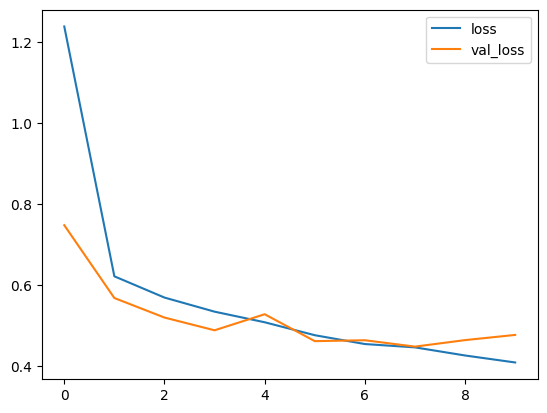

In [ ]:
bi_lstm_model_glove = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')])

bi_lstm_model_glove.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = bi_lstm_model_glove.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [ ]:
test_loss, test_acc = bi_lstm_model_glove.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 16ms/step - loss: 0.4966 - accuracy: 0.8409
Test Loss: 0.49656540155410767
Test Accuracy: 0.8409368395805359


## BiGRU model sa GloVe vektorima

In [113]:
!mkdir models

In [114]:
checkpoint_path = "models/gru_glove.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                monitor="val_loss", mode="min",
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)

Epoch 1/25
385/385 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.7632
Epoch 1: val_loss improved from inf to 0.49267, saving model to models/gru_glove.ckpt
385/385 [==============================] - 19s 39ms/step - loss: 0.6245 - accuracy: 0.7632 - val_loss: 0.4927 - val_accuracy: 0.8148
Epoch 2/25
385/385 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.8206
Epoch 2: val_loss improved from 0.49267 to 0.45437, saving model to models/gru_glove.ckpt
385/385 [==============================] - 14s 36ms/step - loss: 0.4890 - accuracy: 0.8206 - val_loss: 0.4544 - val_accuracy: 0.8216
Epoch 3/25
383/385 [============================>.] - ETA: 0s - loss: 0.4225 - accuracy: 0.8451
Epoch 3: val_loss improved from 0.45437 to 0.39637, saving model to models/gru_glove.ckpt
385/385 [==============================] - 15s 38ms/step - loss: 0.4228 - accuracy: 0.8452 - val_loss: 0.3964 - val_accuracy: 0.8470
Epoch 4/25
384/385 [===========================

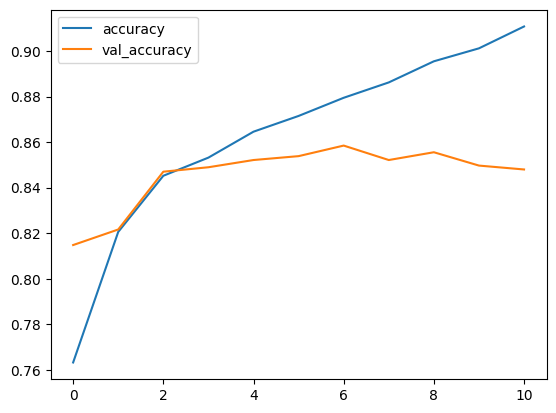

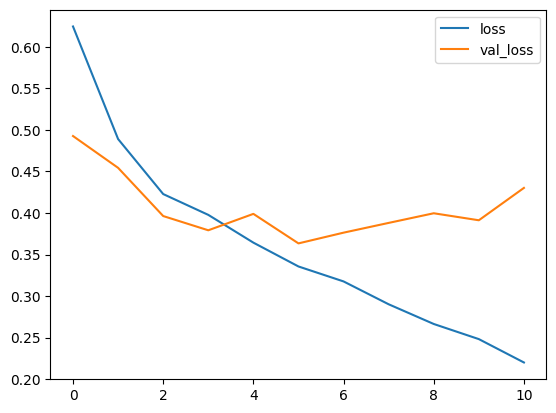

In [115]:
gru_model_glove1 = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    Bidirectional(GRU(64)),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

gru_model_glove1.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model_glove1.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[early_stopping, checkpoint])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

### Evaluacija modela

In [116]:
test_loss, test_acc = gru_model_glove1.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 16ms/step - loss: 0.4494 - accuracy: 0.8500
Test Loss: 0.4493882954120636
Test Accuracy: 0.8499634265899658


In [117]:
y_pred = gru_model_glove1.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1).numpy()

129/129 [==============================] - 3s 20ms/step


In [118]:
# Matrica konfuzije
conf_matrix = confusion_matrix(y_test, y_pred)

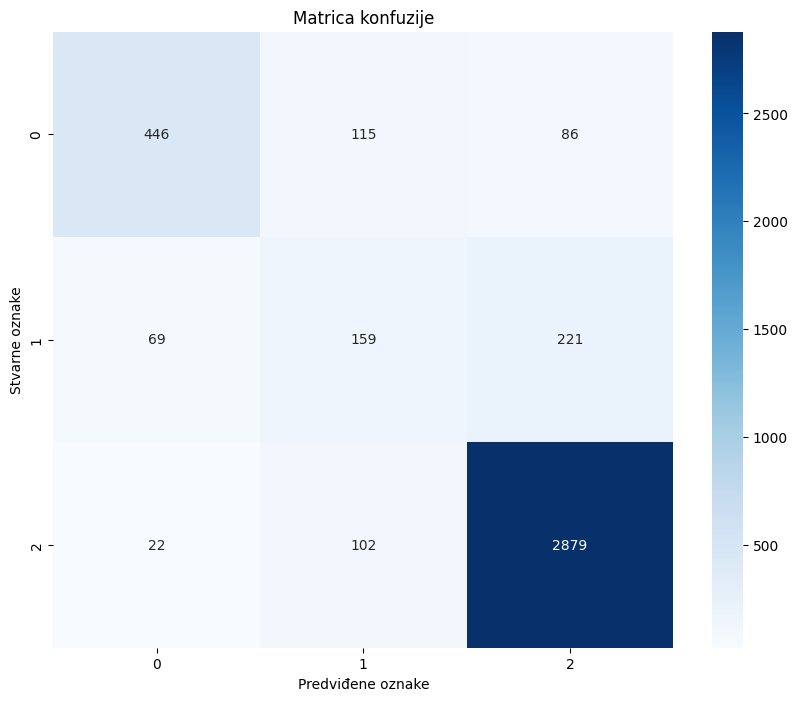

In [119]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predviđene oznake')
plt.ylabel('Stvarne oznake')
plt.title('Matrica konfuzije')
plt.show()

In [120]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(2)

In [121]:
df_report

,precision,recall,f1-score,support
0,0.83,0.69,0.75,647.00
1,0.42,0.35,0.39,449.00
2,0.90,0.96,0.93,3003.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.72,0.67,0.69,4099.00
weighted avg,0.84,0.85,0.84,4099.00


## Primjer klasifikacije komentara

Sada možemo definirati model iste strukture kao `gru_model_glove1` i vratiti težine iz epohe s najboljim performansom (najmanji *loss* u ovom slučaju).

In [122]:
gru_model_glove = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    Bidirectional(GRU(64)),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')])

gru_model_glove.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [123]:
gru_model_glove.load_weights(checkpoint_path)

In [124]:
test_loss, test_acc = gru_model_glove.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 3s 17ms/step - loss: 0.3828 - accuracy: 0.8580
Test Loss: 0.38279637694358826
Test Accuracy: 0.8580141663551331


In [139]:
def classify_comment(comment, model):
    labels = ['Negative', 'Neutral', 'Positive']
    # Ručno pretprocesiranje komentara
    preprocessed_comment = custom_preprocessing_sw_removal(comment)
    # Pretvaranje u TensorFlow Dataset
    ds = tf.data.Dataset.from_tensor_slices([preprocessed_comment])
    ds = ds.batch(1)
    # Predviđanje
    prediction = model.predict(ds)
    return labels[np.argmax(prediction)]

In [140]:
comment = "I was very disappointed with my stay. The room was dirty and the service was unacceptably slow."
prediction = classify_comment(comment, gru_model_glove)
print(f"Predicted Sentiment: {prediction}\n")

1/1 [==============================] - 0s 10ms/step
Predicted Sentiment: Negative



In [156]:
# Komentari/recenzije
positive = ["This hotel exceeded all my expectations, the staff were incredibly helpful and the location was perfect.",
            "Absolutely loved my stay here! The rooms were clean, spacious, and well-equipped.",
            "Fantastic experience! The food was gourmet quality and the service was top-notch."]

negative = ["I was very disappointed with my stay. The room was dirty and the service was unacceptably slow.",
            "Terrible experience. The hotel was noisy, and the staff were rude and unhelpful.",
            "Not worth the price. The facilities were outdated and the bed was uncomfortable."]

In [157]:
for comment in positive + negative:
    print(f"Original Comment: {comment}")
    pred = classify_comment(comment, gru_model_glove)
    print(f"Predicted Sentiment: {pred}\n")
    print()

Original Comment: This hotel exceeded all my expectations, the staff were incredibly helpful and the location was perfect.
1/1 [==============================] - 0s 14ms/step
Predicted Sentiment: Positive


Original Comment: Absolutely loved my stay here! The rooms were clean, spacious, and well-equipped.
1/1 [==============================] - 0s 22ms/step
Predicted Sentiment: Positive


Original Comment: Fantastic experience! The food was gourmet quality and the service was top-notch.
1/1 [==============================] - 0s 20ms/step
Predicted Sentiment: Positive


Original Comment: I was very disappointed with my stay. The room was dirty and the service was unacceptably slow.
1/1 [==============================] - 0s 47ms/step
Predicted Sentiment: Negative


Original Comment: Terrible experience. The hotel was noisy, and the staff were rude and unhelpful.
1/1 [==============================] - 0s 44ms/step
Predicted Sentiment: Negative


Original Comment: Not worth the price. The f